In [15]:
import statistics
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cuda:0


### Model Setup

In [3]:
batch_size = 64
num_classes = 10
epochs = 5

In [4]:
mnist_train = FashionMNIST(root="data", download=True, transform=transforms.ToTensor(), train=True)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

mnist_test = FashionMNIST(root="data", download=True, transform=transforms.ToTensor(), train=False)

test_loader = DataLoader(mnist_test)

100%|██████████| 26421880/26421880 [00:04<00:00, 5462079.17it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 1013275.29it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2800984.03it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7430239.85it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [11]:
# Feed Forward Neural Network

# model architecture from: https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy

class ConvClassifier(nn.Module):
    def __init__(self, num_classes: int, activation_function=nn.ReLU(), loss_fn=nn.CrossEntropyLoss()):
        super().__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activation_function,
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            activation_function,
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64 * 6 * 6, 600),
            nn.Dropout(0.25),
            activation_function,
            nn.Linear(600, 120),
            activation_function,
            nn.Linear(120, num_classes)  # no softmax necessary
        )

        self.num_classes = num_classes
        self.loss_fn = loss_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class MLPClassifier(nn.Module):
    def __init__(self, input_dim: int, num_classes: int, activation_function=nn.ReLU(), loss_fn=nn.CrossEntropyLoss()):
        super().__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=num_classes),
        )

        self.num_classes = num_classes
        self.loss_fn = loss_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc_layers(x)

def train_network(model, dataloader: DataLoader, optimizer: torch.optim.Optimizer):
    model.train()
    losses = []
    for batch, (X, y) in enumerate(tqdm.tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        y_pred = model.forward(X)
        y_true = F.one_hot(y, model.num_classes).type(y_pred.dtype)
        loss = model.loss_fn(y_pred, y_true)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch Train Loss: {statistics.mean(losses)}")

def test(model, dataloader: DataLoader):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    num_correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model.forward(X)
            test_loss += model.loss_fn(y_pred, F.one_hot(y, model.num_classes).type(y_pred.dtype)).item()
            num_correct += (torch.argmax(y_pred, dim=1) == y).sum().item()
    test_loss /= num_batches
    accuracy = num_correct / len(dataloader.dataset)
    print(f"Test Error: Avg loss: {test_loss:>8f} Accuracy: {float(accuracy):>8f} \n")

In [7]:
model = ConvClassifier(num_classes=num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(epochs):
    print(f"Epoch {t+1} -------------------------------")
    train_network(model, train_loader, optimizer)
    test(model, test_loader)

Epoch 1 -------------------------------


100%|██████████| 938/938 [00:16<00:00, 55.68it/s]


Epoch Train Loss: 0.396056069446398
Test Error: Avg loss: 0.321933 Accuracy: 0.882200 

Epoch 2 -------------------------------


100%|██████████| 938/938 [00:22<00:00, 42.59it/s]


Epoch Train Loss: 0.2751697207342333
Test Error: Avg loss: 0.272947 Accuracy: 0.897200 

Epoch 3 -------------------------------


100%|██████████| 938/938 [00:21<00:00, 42.87it/s]


Epoch Train Loss: 0.23646754786562818
Test Error: Avg loss: 0.277904 Accuracy: 0.896600 

Epoch 4 -------------------------------


100%|██████████| 938/938 [00:21<00:00, 42.95it/s]


Epoch Train Loss: 0.20858440878215248
Test Error: Avg loss: 0.244352 Accuracy: 0.913000 

Epoch 5 -------------------------------


100%|██████████| 938/938 [00:21<00:00, 42.81it/s]


Epoch Train Loss: 0.1862530274304754
Test Error: Avg loss: 0.251850 Accuracy: 0.911100 



In [12]:
linear_model = MLPClassifier(input_dim=28*28, num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(epochs):
    print(f"Epoch {t+1} -------------------------------")
    train_network(model, train_loader, optimizer)
    test(model, test_loader)

Epoch 1 -------------------------------


100%|██████████| 938/938 [00:19<00:00, 48.90it/s]


Epoch Train Loss: 0.1717448293813256
Test Error: Avg loss: 0.246304 Accuracy: 0.916700 

Epoch 2 -------------------------------


100%|██████████| 938/938 [00:22<00:00, 42.63it/s]


Epoch Train Loss: 0.15000982595079426
Test Error: Avg loss: 0.237665 Accuracy: 0.918500 

Epoch 3 -------------------------------


100%|██████████| 938/938 [00:22<00:00, 42.57it/s]


Epoch Train Loss: 0.13310702160390012
Test Error: Avg loss: 0.232767 Accuracy: 0.921300 

Epoch 4 -------------------------------


100%|██████████| 938/938 [00:22<00:00, 42.12it/s]


Epoch Train Loss: 0.11939699739626826
Test Error: Avg loss: 0.246738 Accuracy: 0.920000 

Epoch 5 -------------------------------


100%|██████████| 938/938 [00:22<00:00, 42.15it/s]


Epoch Train Loss: 0.1036366860740689
Test Error: Avg loss: 0.274791 Accuracy: 0.915900 



### Attacks

In [19]:
def showImage(image):
    plt.imshow(image[0][0], cmap='gray', interpolation='none')
    plt.show()

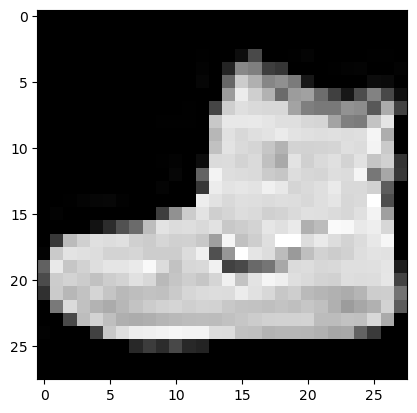

In [20]:
showImage(mnist_train[0])